In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

### put the helper functions together
 - define the font up front 

In [2]:
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

### get data ready
 - read data
 - format the columns and column names 
 - add language detection
 - filter by agreement and language

 - language detection takes long time, on the full SDG dataset, it takes neara 3 minutes
 - may not want to run it unless really needed, or run it after filtering by other dimensions

In [3]:
text_df = pd.read_csv("/Users/yingli/Downloads/osdg-community-data-v2023-01-01.csv", sep = "\t", quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
#text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
#text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True)

In [4]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

### using count vectors on multinomialNB

              precision    recall  f1-score   support

           1     0.7223    0.8274    0.7713       481
           2     0.8475    0.7563    0.7993       316
           3     0.8926    0.9243    0.9082       674
           4     0.8338    0.9479    0.8872       863
           5     0.7570    0.9380    0.8379       920
           6     0.8653    0.8839    0.8745       465
           7     0.7469    0.9096    0.8203       730
           8     0.8125    0.3314    0.4708       353
           9     0.8497    0.5000    0.6296       328
          10     0.7970    0.4141    0.5450       256
          11     0.8383    0.7294    0.7801       462
          12     0.9098    0.5115    0.6549       217
          13     0.7243    0.8600    0.7864       443
          14     0.9171    0.6730    0.7763       263
          15     0.8987    0.6805    0.7745       313
          16     0.8860    0.9849    0.9328      1057

    accuracy                         0.8184      8141
   macro avg     0.8312   

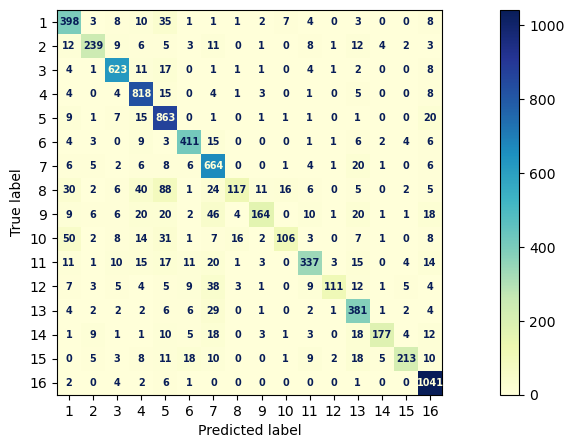

In [5]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train)  
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"])
print(metrics.classification_report(y_test,y_pred, digits = 4))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))


### using tfidf vectors on MultinomialNB
 - set min_df = 5
 - max_df did not seem to impact the accuracy as much, unless it is below a few percent, which might be too low anyways

              precision    recall  f1-score   support

           1       0.74      0.74      0.74       481
           2       0.85      0.44      0.58       316
           3       0.82      0.84      0.83       674
           4       0.68      0.90      0.78       863
           5       0.63      0.89      0.74       920
           6       0.86      0.81      0.83       465
           7       0.61      0.89      0.72       730
           8       0.81      0.11      0.19       353
           9       0.83      0.23      0.37       328
          10       0.87      0.23      0.36       256
          11       0.78      0.61      0.68       462
          12       0.93      0.29      0.44       217
          13       0.78      0.74      0.76       443
          14       0.93      0.35      0.51       263
          15       0.91      0.50      0.64       313
          16       0.68      0.98      0.80      1057

    accuracy                           0.71      8141
   macro avg       0.79   

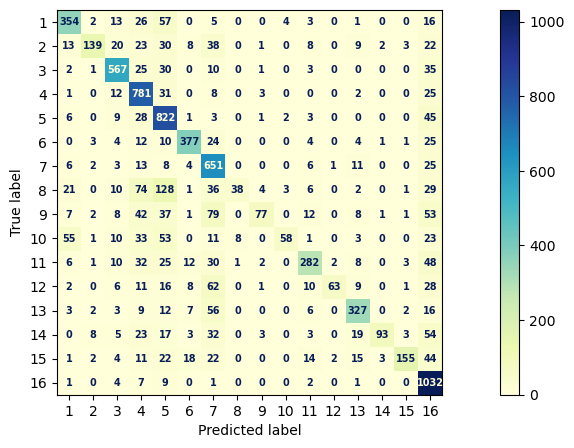

In [6]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

tfidf_multinomialNB_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomialNB_clf.predict(X_test_tfidf_vector)

print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax,cmap=mpl.colormaps["YlGnBu"])


### observation on computation cost
 - when doing
    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)
 - vs. doing

    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train).toaray()\
    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test).toarray()
 - adding .toarray() make the model fitting and prediction much slower
 - the former (without toarray()) is about 10 second, on (2, 2) tfidf
 - the later is about 5 minutes

### using MLPClassifier

### using MLPClassifier
 - MLPClassifier takes very long if we use toekns beyond unigram
 - it was taking more than 3 hours on my mac and still not finishing when fed with bigram
 - if set min_df = 2 or above, it would complete the run
 - or we can run on fewer SDGs

 - use full SDG, min_df = 5 it took 5 min 11 sec to complete
  - min_df = 4 took 8 minutes

In [7]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.78      0.74      0.76       481
           2       0.50      0.68      0.58       316
           3       0.77      0.84      0.81       674
           4       0.84      0.83      0.83       863
           5       0.81      0.85      0.83       920
           6       0.80      0.82      0.81       465
           7       0.78      0.81      0.80       730
           8       0.54      0.38      0.45       353
           9       0.54      0.56      0.55       328
          10       0.51      0.47      0.49       256
          11       0.65      0.67      0.66       462
          12       0.67      0.51      0.58       217
          13       0.77      0.74      0.76       443
          14       0.68      0.66      0.67       263
          15       0.76      0.68      0.72       313
          16       0.94      0.93      0.93      1057

    accuracy                           0.76      8141
   macro avg       0.71   

In [8]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.79      0.81      0.80       481
           2       0.82      0.87      0.84       316
           3       0.94      0.93      0.94       674
           4       0.92      0.94      0.93       863
           5       0.92      0.92      0.92       920
           6       0.90      0.91      0.91       465
           7       0.88      0.88      0.88       730
           8       0.68      0.61      0.64       353
           9       0.79      0.80      0.79       328
          10       0.64      0.58      0.61       256
          11       0.85      0.88      0.86       462
          12       0.85      0.78      0.81       217
          13       0.85      0.87      0.86       443
          14       0.93      0.92      0.93       263
          15       0.89      0.85      0.87       313
          16       0.97      0.97      0.97      1057

    accuracy                           0.88      8141
   macro avg       0.85   

In [9]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words = "english", min_df=7)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, hidden_layer_sizes = (100, 70), max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.78      0.79      0.79       481
           2       0.82      0.85      0.84       316
           3       0.93      0.91      0.92       674
           4       0.90      0.93      0.91       863
           5       0.91      0.91      0.91       920
           6       0.89      0.91      0.90       465
           7       0.87      0.88      0.88       730
           8       0.63      0.58      0.60       353
           9       0.75      0.77      0.76       328
          10       0.63      0.59      0.61       256
          11       0.83      0.86      0.85       462
          12       0.81      0.74      0.77       217
          13       0.84      0.85      0.84       443
          14       0.91      0.88      0.90       263
          15       0.87      0.85      0.86       313
          16       0.96      0.97      0.96      1057

    accuracy                           0.86      8141
   macro avg       0.83   

In [10]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, hidden_layer_sizes = (100, 70), max_iter=300).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.80      0.79      0.80       481
           2       0.84      0.86      0.85       316
           3       0.91      0.92      0.92       674
           4       0.91      0.93      0.92       863
           5       0.91      0.92      0.91       920
           6       0.86      0.89      0.87       465
           7       0.86      0.87      0.87       730
           8       0.67      0.61      0.64       353
           9       0.80      0.77      0.79       328
          10       0.60      0.56      0.58       256
          11       0.82      0.84      0.83       462
          12       0.81      0.76      0.78       217
          13       0.82      0.84      0.83       443
          14       0.92      0.90      0.91       263
          15       0.85      0.84      0.84       313
          16       0.96      0.96      0.96      1057

    accuracy                           0.86      8141
   macro avg       0.83   

In [11]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, hidden_layer_sizes = (100), max_iter=300).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.78      0.74      0.76       481
           2       0.50      0.68      0.58       316
           3       0.77      0.84      0.81       674
           4       0.84      0.83      0.83       863
           5       0.81      0.85      0.83       920
           6       0.80      0.82      0.81       465
           7       0.78      0.81      0.80       730
           8       0.54      0.38      0.45       353
           9       0.54      0.56      0.55       328
          10       0.51      0.47      0.49       256
          11       0.65      0.67      0.66       462
          12       0.67      0.51      0.58       217
          13       0.77      0.74      0.76       443
          14       0.68      0.66      0.67       263
          15       0.76      0.68      0.72       313
          16       0.94      0.93      0.93      1057

    accuracy                           0.76      8141
   macro avg       0.71   

In [12]:
tfidf_mlp_clf.n_features_in_

14980

In [13]:
select_sdg = [2,3,4,8,9,10,14,15,16]
docs = text_df.query("sdg in @select_sdg").text
categories = text_df.query("sdg in @select_sdg").sdg
X_train, X_test, y_train, y_test = train_test_split(
    docs, categories, test_size=0.33, random_state=7)

X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

 -  max_iter of 100, 200, 300, did not seem to make a difference in speed nor accuracy

 - this below took 89min 35.6 sec to finish.

 - RidgeClassifier seems to be giving best results compared with MultinomialNB, and NN

              precision    recall  f1-score   support

           2     0.8589    0.7843    0.8199       357
           3     0.8555    0.9214    0.8872       649
           4     0.8064    0.9522    0.8732       879
           8     0.8243    0.5351    0.6489       342
           9     0.8364    0.6725    0.7455       342
          10     0.8061    0.6695    0.7315       236
          14     0.9659    0.7148    0.8216       277
          15     0.9216    0.7841    0.8473       315
          16     0.8448    0.9852    0.9096      1011

    accuracy                         0.8455      4408
   macro avg     0.8578    0.7799    0.8094      4408
weighted avg     0.8486    0.8455    0.8393      4408



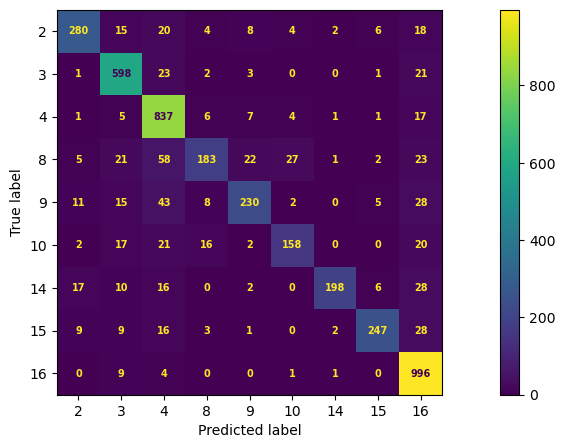

In [15]:
from sklearn.linear_model import RidgeClassifier

X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english", min_df=1)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
tfidf_ridge_clf = tfidf_ridge_clf.fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_ridge_clf.predict(X_test_tfidf_vector)
print(metrics.classification_report(y_test,y_pred, digits = 4))
fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax)

### notice the assymetry in the misclassifications
 - SDG 8 got classified into many other SDGs, but not the other way, except more of SDG 10 got classified into SDG8 
 - see if you can get the feature effect code working
 https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
 

In [16]:
X_test_tfidf_vector

<4408x361763 sparse matrix of type '<class 'numpy.float64'>'
	with 81484 stored elements in Compressed Sparse Row format>

In [17]:
tfidf_ridge_clf.coef_.shape

(9, 361763)

In [24]:


def most_significant_feature_for_class(vectorizer, vector, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        average_feature_effects = classifier.coef_ * np.asarray(vector.mean(axis=0)).ravel()
        top_n = sorted(zip(average_feature_effects[labelid], feature_names), reverse=True)[:n]
        bottom_n = sorted(zip(average_feature_effects[labelid], feature_names))[:n]

        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
        for coef, feat in bottom_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")



In [25]:
most_significant_feature_for_class(X_train_tfidf_vectorizer, X_train_tfidf_vector,tfidf_ridge_clf, [1], n=30)


SDG 1 : health care                     0.022256
SDG 1 : primary care                    0.00764852
SDG 1 : mental health                   0.00610612
SDG 1 : et al                           0.00429256
SDG 1 : health services                 0.0029888
SDG 1 : public health                   0.00252039
SDG 1 : oecd countries                  0.00221032
SDG 1 : life expectancy                 0.00190672
SDG 1 : long term                       0.00169448
SDG 1 : health insurance                0.0014509
SDG 1 : indigenous peoples              0.00130764
SDG 1 : ministry health                 0.0011488
SDG 1 : hiv aids                        0.00106516
SDG 1 : quality care                    0.00101642
SDG 1 : risk factors                    0.000969222
SDG 1 : health outcomes                 0.000968298
SDG 1 : health systems                  0.000954634
SDG 1 : alcohol consumption             0.000898799
SDG 1 : care services                   0.00088532
SDG 1 : health status           